# LITS - Liver Tumor Segmentation

This (Google Colab intended) notebook creates a U-Net model which partially uses layers from a MobileNet model to perform image segmentation on (potentially) cancerous livers.

## Get Data

We first download data from Kaggle. The Kaggle dataset has the data stored as 2 directories (image and mask) of jpegs indexed by patient id and time-slice index, as opposed to storing the data as NIFTI files indexed by patient id. In practice, it would be more natural to store the data in NIFTI files, however the jpeg version of the data is smaller (since we only care about 1 of the 3 anatomical planes in each NIFTI), and since we will only be using a subset of the data, having jpegs is more convenient since we won't have to randomly sample and then save time-slices from the NIFTIs.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pwd # Print working directory (GoogleColab Session Disk)

# Copy file containing KaggleAPI call parameters to working directory
! mkdir ~/.kaggle
! cp drive/MyDrive/colab/liver_tumor_segmentation/kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

# Download data from Kaggle
! kaggle datasets download -d harshwardhanbhangale/lits-dataset --unzip

# Rename directories
! mv train_images images
! mv images/train_images images/images
! mv train_masks masks
! mv masks/train_masks masks/masks

# Copy imports from Colab to working directory
! cp drive/MyDrive/colab/liver_tumor_segmentation/model.py model.py
! cp drive/MyDrive/colab/liver_tumor_segmentation/custom_tf.py custom_tf.py

# Display working directory contents
! ls

/content
 98% 1.38G/1.40G [00:11<00:00, 201MB/s]
100% 1.40G/1.40G [00:11<00:00, 129MB/s]
custom_tf.py  drive  images  masks  model.py  sample_data  test.jpg


# Data Preparation

In [35]:
import typing

import os
import re
import glob
import math
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt; plt.style.use('dark_background')
from sklearn.model_selection import train_test_split

import tensorflow as tf
from model import get_liver_segmentation_unet
from custom_tf import DiceScore, MaskProgressSave, BatchLoss

In [4]:
IMG_DIR = os.path.join(os.getcwd(), 'images', 'images')
MASK_DIR = os.path.join(os.getcwd(), 'masks', 'masks')

def get_scan_idx(path): # Get scan index from image / mask path
    fname = os.path.split(path)[-1]
    return int(re.search('\d+', fname).group())

def get_slice_idx(path): # Get time-index from image / mask path
    fname = os.path.split(path)[-1]
    return int(re.findall('\d+', fname)[-1])

def sort_key(path): # Key for sorting images
    return get_scan_idx(path), get_slice_idx(path)

def load_paths_array(img_dir, mask_dir):

    img_path_re_str = os.path.join(img_dir, '*.jpg')
    mask_path_re_str = os.path.join(mask_dir, '*.jpg')

    img_paths = sorted(glob.glob(img_path_re_str), key=sort_key)
    mask_paths = sorted(glob.glob(mask_path_re_str), key=sort_key)

    N = len(img_paths)

    P = []

    for i, (x_path, y_path) in enumerate(zip(img_paths, mask_paths)):

        # Check image and mask correspond to same patient-time-slice
        x_vol_slice = re.findall('\d+', x_path)
        y_vol_slice = re.findall('\d+', y_path)
        fail_msg = f'file indices don\'t match: {x_vol_slice} != {y_vol_slice}'
        assert x_vol_slice == y_vol_slice, fail_msg

        scan_idx = int(x_vol_slice[0])
        P.append((str(scan_idx), x_path, y_path))

    return np.stack(P, axis=0)

PATHS = load_paths_array(IMG_DIR, MASK_DIR)
print(PATHS.shape)
PATHS[:5]

(58638, 3)


array([['0', '/content/images/images/volume-0_slice_0.jpg',
        '/content/masks/masks/volume-0_slice_0.jpg'],
       ['0', '/content/images/images/volume-0_slice_1.jpg',
        '/content/masks/masks/volume-0_slice_1.jpg'],
       ['0', '/content/images/images/volume-0_slice_2.jpg',
        '/content/masks/masks/volume-0_slice_2.jpg'],
       ['0', '/content/images/images/volume-0_slice_3.jpg',
        '/content/masks/masks/volume-0_slice_3.jpg'],
       ['0', '/content/images/images/volume-0_slice_4.jpg',
        '/content/masks/masks/volume-0_slice_4.jpg']], dtype='<U47')

### Split Data

Since we mapped each image/mask pair to its patient, we can split training/validation/testing data by scan and not simply by images. This is more useful since a model will be trained and evaluated on different patients, rather than different images from the same patients. The data is also subsetted randomly since using the entire dataset is unnecessary for our model's training to converge.

In [5]:
# Total number of scans in dataset
n_scan = PATHS[:, 0].astype(int).max() # <--- 130

train_scan_idx, test_scan_idx = train_test_split(
    np.arange(n_scan).astype(str),
    test_size=0.25,
    random_state=0
)

train_scan_idx, valid_scan_idx = train_test_split(
    train_scan_idx.astype(str),
    test_size=0.20,
    random_state=1
)

train_paths = PATHS[np.isin(PATHS[:, 0], train_scan_idx)]
valid_paths = PATHS[np.isin(PATHS[:, 0], valid_scan_idx)]
test_paths = PATHS[np.isin(PATHS[:, 0], test_scan_idx)]

print(f'train scans, train n_slices:', 
      len(train_scan_idx), ',', train_paths.shape[0]
)
print(f'valid n_scans, valid n_slices:', 
      len(valid_scan_idx), ',', valid_paths.shape[0]
)
print(f'test scans, test n_slices:', 
      len(test_scan_idx), ',', test_paths.shape[0]
)

train scans, train n_slices: 77 , 33436
valid n_scans, valid n_slices: 20 , 10748
test scans, test n_slices: 33 , 13830


In [6]:
# Randomly subset data to reduce training time (all data is unnecessary)
N_train, N_valid, N_test = 10000, 2000, 3000

def get_paths_subset(paths: np.ndarray, N: int, seed: int):
    np.random.seed(seed)
    idx = np.random.choice(np.arange(paths.shape[0]), size=N, replace=False)
    return paths[idx]

train_paths_subset = get_paths_subset(train_paths, N_train, 10)
valid_paths_subset = get_paths_subset(valid_paths, N_valid, 11)
test_paths_subset = get_paths_subset(test_paths, N_test, 100)

train_paths_subset[:5]

array([['39', '/content/images/images/volume-39_slice_208.jpg',
        '/content/masks/masks/volume-39_slice_208.jpg'],
       ['116', '/content/images/images/volume-116_slice_204.jpg',
        '/content/masks/masks/volume-116_slice_204.jpg'],
       ['117', '/content/images/images/volume-117_slice_685.jpg',
        '/content/masks/masks/volume-117_slice_685.jpg'],
       ['123', '/content/images/images/volume-123_slice_274.jpg',
        '/content/masks/masks/volume-123_slice_274.jpg'],
       ['43', '/content/images/images/volume-43_slice_56.jpg',
        '/content/masks/masks/volume-43_slice_56.jpg']], dtype='<U47')

### Save Preprocessed Data

Our model will have an input shape of (224, 224, 3), so we will ensure each image has that shape. We also save each time-slice as a numpy array (avoids conversion of JPG to numpy) and perform some other preprocessing.

Rather than resize each image individually, we will stack images and perform (batched) processing to them, and then save each image to its corresponding file. A priori, I know all JPGs are of shape (256, 256).

In [7]:
def read_image(jpg_path):
    jpg = Image.open(jpg_path)
    return np.array(jpg)    

def preprocess_save_stack(
    A_list: typing.List[np.ndarray], 
    paths: typing.List[os.PathLike],
    destination_directory: os.PathLike,
    resize_method: tf.image.ResizeMethod,
    are_masks: bool
):

    assert len(A_list) == len(paths), 'stack and paths have different lengths'
    
    A = np.stack(A_list, axis=0)

    if len(A.shape) == 3:
        A = np.expand_dims(A, axis=-1)

    A = np.rot90(A, axes=(1, 2))
    A = tf.image.resize(A, (224, 224), resize_method).numpy()
    A = A.squeeze()

    if are_masks: # Save each mask with one-hot encoded classes
        A = tf.one_hot(A, depth=3, axis=-1).numpy().astype(int)
    else: A /= 255.

    for t, p in enumerate(paths):
        a = A[t]
        a_path = p.replace('.jpg', '')
        a_fname = os.path.split(a_path)[-1]
        a_path = os.path.join(destination_directory, a_fname)
        np.save(a_path, a)

    A_list.clear()
    paths.clear()

def preprocess_path_array(
    paths: np.ndarray, 
    destination_directory: os.PathLike,
    tqdm_desc=''
):

    destination_x_directory = os.path.join(destination_directory, 'images')
    destination_y_directory = os.path.join(destination_directory, 'masks')

    if not os.path.exists(destination_directory):
        os.mkdir(destination_directory)

    if not os.path.exists(destination_x_directory):
        os.mkdir(destination_x_directory)

    if not os.path.exists(destination_y_directory):
        os.mkdir(destination_y_directory)

    x_resize_method = tf.image.ResizeMethod.BILINEAR
    y_resize_method = tf.image.ResizeMethod.NEAREST_NEIGHBOR

    X, Y = [], []
    X_paths, Y_paths = [], []

    for i in tqdm(range(paths.shape[0]), desc=tqdm_desc):

        _, x_path, y_path = paths[i]

        x_vol_slice = re.findall('\d+', x_path)
        y_vol_slice = re.findall('\d+', y_path)

        # Check that image and mask correspond to same scan-time slice
        fail_msg = f'file indices don\'t match: {x_vol_slice} != {y_vol_slice}'
        assert x_vol_slice == y_vol_slice, fail_msg

        x = read_image(x_path)
        y = read_image(y_path)

        if len(X) < 1000:
            X.append(x)
            X_paths.append(x_path)
        else: 
            preprocess_save_stack(
                X, X_paths, destination_x_directory, x_resize_method, False
            )

        if len(Y) < 1000:
            Y.append(y)
            Y_paths.append(y_path)        
        else:
            preprocess_save_stack(
                Y, Y_paths, destination_y_directory, y_resize_method, True
            )

    if len(X) != 0:
        preprocess_save_stack(
            X, X_paths, destination_x_directory, x_resize_method, False
        )

    if len(y) != 0:
        preprocess_save_stack(
            Y, Y_paths, destination_y_directory, y_resize_method, True
        )

In [8]:
np_dir = os.path.join(os.getcwd(), 'numpy_data')

if not os.path.exists(np_dir):
    os.mkdir(np_dir)

np_train_dir = os.path.join(np_dir, 'train')
np_valid_dir = os.path.join(np_dir, 'valid')
np_test_dir = os.path.join(np_dir, 'test')

preprocess_path_array(train_paths_subset, np_train_dir, 'Training data: ')
preprocess_path_array(valid_paths_subset, np_valid_dir, 'Validation data: ')
preprocess_path_array(test_paths_subset, np_test_dir, 'Testing data: ')

Testing data: 100%|██████████| 3000/3000 [00:33<00:00, 89.90it/s] 


In [9]:
# We won't need the jpeg version of the entire dataset anymore
shutil.rmtree('images')
shutil.rmtree('masks')

## Data Sample

In [10]:
def window(scan_img: np.ndarray):
    DICOM_LIVER_WINDOWS = (150, 30)
    w, l = DICOM_LIVER_WINDOWS
    px_min, px_max = l - w // 2, l + w // 2
    return (scan_img.clip(px_min, px_max) - px_min) / (px_max - px_min)

def plot_scan_and_segmentation(scan_img, mask_img):

    _, axs = plt.subplots(
        1, 3, figsize=(8, 12), subplot_kw={'xticks': [], 'yticks': []}
    )

    mask = mask_img.argmax(axis=-1)

    axs[0].imshow(scan_img)
    axs[0].set_title('Raw Image')

    axs[1].imshow(mask, alpha=0.5, cmap='gray')
    axs[1].set_title('Mask')

    axs[2].imshow(scan_img)
    axs[2].imshow(mask, alpha=0.5, cmap='gray')
    axs[2].set_title('Image and Mask')

    plt.show()

def find_cancerous_liver_paths(
    directory: os.PathLike,
    n_livers: int = 3, 
    fraction_cancerous: float = 0.02,
):

    img_dir = os.path.join(directory, 'images')
    mask_dir = os.path.join(directory, 'masks')

    img_paths = glob.glob(os.path.join(img_dir, '*.npy'))
    mask_paths = glob.glob(os.path.join(mask_dir, '*.npy'))

    cancerous_paths = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        mask = np.load(mask_path)
        if mask[..., -1].mean() >= fraction_cancerous:
            cancerous_paths.append((img_path, mask_path))
        if len(cancerous_paths) == n_livers:
            return cancerous_paths
    return cancerous_paths

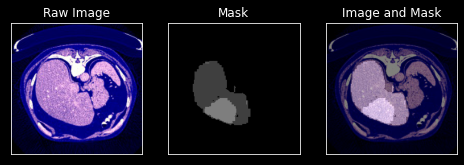

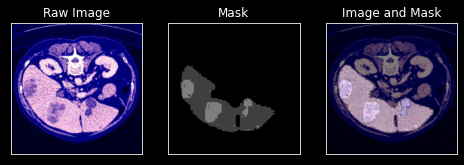

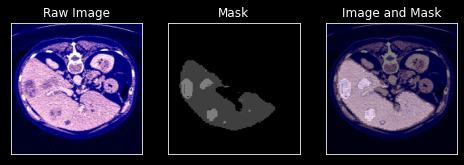

In [11]:
for img_path, mask_path in find_cancerous_liver_paths(np_train_dir):
    img, mask = np.load(img_path), np.load(mask_path)
    plot_scan_and_segmentation(img, mask)

In [12]:
# Get image from testing set to see progression of model's performance
sample_x, sample_y = find_cancerous_liver_paths(np_test_dir, 1)[0]
sample_x, sample_y = np.load(sample_x), np.load(sample_y)

## Model Training

In [13]:
class LiverTumorSequence(tf.keras.utils.Sequence):

    def __init__(self, root_directory: os.PathLike, batch_size: int = 32):
        x_dir = os.path.join(root_directory, 'images')
        y_dir = os.path.join(root_directory, 'masks')

        self.x_paths = np.array(glob.glob(os.path.join(x_dir, '*.npy')))
        self.y_paths = np.array(glob.glob(os.path.join(y_dir, '*.npy')))
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x_paths) / self.batch_size)

    def __getitem__(self, idx):
        _x = self.x_paths[idx*self.batch_size : (idx+1)*self.batch_size]
        _y = self.y_paths[idx*self.batch_size : (idx+1)*self.batch_size]

        x = np.array([np.load(__x) for __x in _x])
        y = np.array([np.load(__y) for __y in _y])

        return x, y

In [14]:
train_seq = LiverTumorSequence(np_train_dir)
valid_seq = LiverTumorSequence(np_valid_dir)
test_seq = LiverTumorSequence(np_test_dir)

In [15]:
u_net = get_liver_segmentation_unet(3, (224, 224, 3))
print('n_params (million):', u_net.count_params()/10**6)

12683000/12683000 [==============================] - 0s 0us/step
n_params (million): 55.644763


In [16]:
u_net.summary()

Model: "u_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp_x (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 112, 112, 6  19587072    ['inp_x[0][0]']                  
                                4),                                                               
                                 (None, 56, 56, 72)                                               
                                , (None, 28, 28, 12                                               
                                0),                                                           

In [17]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
dice_score = DiceScore()

u_net.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[accuracy, dice_score],
)

In [18]:
CHECKPOINT_DIR = os.path.join('.', 'model_checkpoints')
MASK_PROGRESS_DIR = os.path.join('.', 'mask_progress')
LOGS_DIR = os.path.join('.', 'logs')
BATCH_LOSS_PATH = os.path.join(LOGS_DIR, 'batch_loss.csv')

for dir_name in (CHECKPOINT_DIR, MASK_PROGRESS_DIR, LOGS_DIR):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

ckpt_clbk = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_DIR, monitor='val_loss', save_best_only=True
)

mask_progress_clbk = MaskProgressSave(
    sample_x, sample_y, MASK_PROGRESS_DIR
)

board_clbk = tf.keras.callbacks.TensorBoard(LOGS_DIR)
batch_loss_clbk = BatchLoss(BATCH_LOSS_PATH)

callbacks = [
    ckpt_clbk,
    mask_progress_clbk,
    batch_loss_clbk,
]

In [19]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

u_net.fit(
    train_seq,
    epochs=9,
    steps_per_epoch=300,
    validation_data=valid_seq,
    validation_steps=50,
    callbacks=callbacks
);

Epoch 1/9
300/300 [==============================] - ETA: 0s - loss: 0.1497 - categorical_accuracy: 0.9523 - dice_score: 166.0079

300/300 [==============================] - 203s 596ms/step - loss: 0.1497 - categorical_accuracy: 0.9523 - dice_score: 166.0079 - val_loss: 0.0844 - val_categorical_accuracy: 0.9826 - val_dice_score: 91.5426
Epoch 2/9
300/300 [==============================] - ETA: 0s - loss: 0.0219 - categorical_accuracy: 0.9951 - dice_score: 75.2583

300/300 [==============================] - 187s 624ms/step - loss: 0.0219 - categorical_accuracy: 0.9951 - dice_score: 75.2583 - val_loss: 0.0275 - val_categorical_accuracy: 0.9920 - val_dice_score: 92.5196
Epoch 3/9
300/300 [==============================] - 139s 462ms/step - loss: 0.0152 - categorical_accuracy: 0.9962 - dice_score: 94.8618 - val_loss: 0.0317 - val_categorical_accuracy: 0.9920 - val_dice_score: 92.5750
Epoch 4/9
300/300 [==============================] - ETA: 0s - loss: 0.0121 - categorical_accuracy: 0.9967 - dice_score: 153.3314

300/300 [==============================] - 159s 528ms/step - loss: 0.0121 - categorical_accuracy: 0.9967 - dice_score: 153.3314 - val_loss: 0.0266 - val_categorical_accuracy: 0.9935 - val_dice_score: 92.7100
Epoch 5/9
300/300 [==============================] - ETA: 0s - loss: 0.0092 - categorical_accuracy: 0.9972 - dice_score: 82.2271 

300/300 [==============================] - 159s 528ms/step - loss: 0.0092 - categorical_accuracy: 0.9972 - dice_score: 82.2271 - val_loss: 0.0152 - val_categorical_accuracy: 0.9958 - val_dice_score: 92.9979
Epoch 6/9
300/300 [==============================] - ETA: 0s - loss: 0.0074 - categorical_accuracy: 0.9977 - dice_score: 120.4889

300/300 [==============================] - 165s 550ms/step - loss: 0.0074 - categorical_accuracy: 0.9977 - dice_score: 120.4889 - val_loss: 0.0146 - val_categorical_accuracy: 0.9959 - val_dice_score: 93.0539
Epoch 7/9
300/300 [==============================] - 139s 462ms/step - loss: 0.0064 - categorical_accuracy: 0.9979 - dice_score: 149.7506 - val_loss: 0.0185 - val_categorical_accuracy: 0.9952 - val_dice_score: 92.9014
Epoch 8/9
300/300 [==============================] - 134s 447ms/step - loss: 0.0058 - categorical_accuracy: 0.9981 - dice_score: 171.7058 - val_loss: 0.0149 - val_categorical_accuracy: 0.9959 - val_dice_score: 93.0281
Epoch 9/9
300/300 [==============================] - 137s 457ms/step - loss: 0.0053 - categorical_accuracy: 0.9982 - dice_score: 89.7646 - val_loss: 0.0150 - val_categorical_accuracy: 0.9959 - val_dice_score: 93.0306


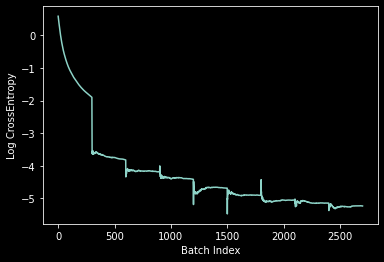

In [48]:
batch_loss = pd.read_csv('logs/batch_loss.csv', header=None).to_numpy()
plt.plot(np.log(batch_loss))
plt.xlabel('Batch Index')
plt.ylabel('Log CrossEntropy')
plt.show()

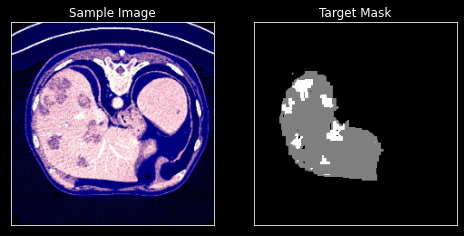

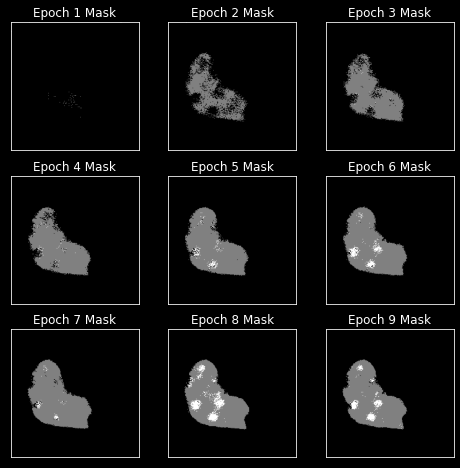

In [52]:
sample_x_path = os.path.join(MASK_PROGRESS_DIR, 'image.npy')
sample_y_path = os.path.join(MASK_PROGRESS_DIR, 'target_mask.npy')
sample_x, sample_y = np.load(sample_x_path), np.load(sample_y_path)

_, axs = plt.subplots(
    1, 2, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []}
)

axs[0].imshow(sample_x)
axs[0].set_title('Sample Image')

axs[1].imshow(sample_y.argmax(axis=-1), cmap='gray')
axs[1].set_title('Target Mask')

plt.show()

sample_mask_paths = sorted(
    glob.glob(os.path.join(MASK_PROGRESS_DIR, 'epoch_*.npy')),
    key=lambda x: int(re.search('\d+', x).group())
)

nrows = max(1, len(sample_mask_paths) // 3)
ncols = min(3, len(sample_mask_paths))
_, axs = plt.subplots(
    nrows, ncols, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []}
)

for i, (mask_path, ax) in enumerate(zip(sample_mask_paths, axs.reshape(-1,))):
    mask = np.load(mask_path)
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'Epoch {i+1} Mask')

plt.show()

In [24]:
# Save model results to Drive
! cp -r logs drive/MyDrive/colab/liver_tumor_segmentation
! cp -r mask_progress drive/MyDrive/colab/liver_tumor_segmentation
! cp -r model_checkpoints drive/MyDrive/colab/liver_tumor_segmentation

In [25]:
u_net.evaluate(test_seq, batch_size=32)

94/94 [==============================] - 36s 381ms/step - loss: 0.0117 - categorical_accuracy: 0.9967 - dice_score: 147.1680


[0.01171811018139124, 0.9966749548912048, 147.16802978515625]

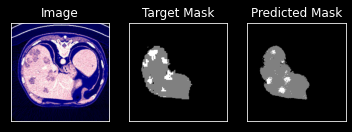

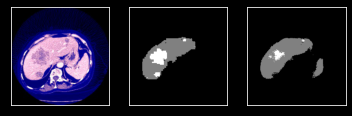

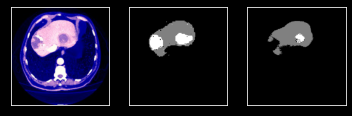

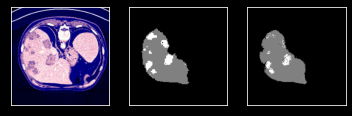

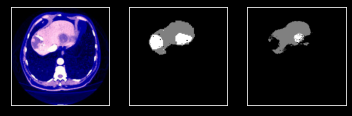

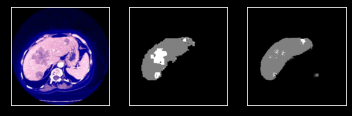

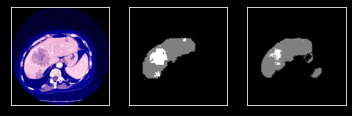

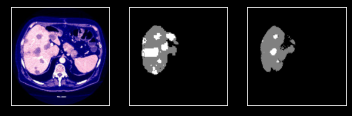

In [54]:
# See model's performance on unseen test images

test_cancerous_livers_paths = find_cancerous_liver_paths(np_test_dir, 8)
test_x = np.array([np.load(p[0]) for p in test_cancerous_livers_paths])
test_y = np.array([np.load(p[1]) for p in test_cancerous_livers_paths])

test_y = test_y.argmax(axis=-1)
test_y_hat = u_net(test_x).numpy().argmax(axis=-1)

for i in range(test_x.shape[0]):
    _, axs = plt.subplots(
        1, 3, figsize=(6, 8), subplot_kw={'xticks': [], 'yticks': []}
    )

    x, y, y_hat = test_x[i], test_y[i], test_y_hat[i]

    axs[0].imshow(x)
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(y_hat, cmap='gray')

    if i == 0:
        axs[0].set_title('Image')
        axs[1].set_title('Target Mask')
        axs[2].set_title('Predicted Mask')

    plt.show()